# Regresión lineal para charn

### Librerías

In [5]:
# Generales y manejo de datos
import pandas as pd
import numpy as np
import os
import logging

# Visualización
import matplotlib.pyplot as plt

# Conexión a SQL Server
import pyodbc  

# Modelado y evaluación
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

## Df clientes

In [6]:
# Configuración de logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Configuración de conexión a SQL Server LOCAL
LOCAL_SERVER = "localhost"
LOCAL_DATABASE = "master"
LOCAL_DRIVER = "{ODBC Driver 17 for SQL Server}"

local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"

# Ruta a la carpeta con los archivos SQL
SQL_FOLDER_PATH = "../sql/dimensionality_reduction/"
SQL_FILE = "SQLQuery_Customer.sql"

# Leer la consulta desde el archivo SQL
with open(f"{SQL_FOLDER_PATH}{SQL_FILE}", "r", encoding="iso-8859-1") as file:
    query = file.read()

# Conectar a SQL Server y ejecutar la consulta
try:
    conn = pyodbc.connect(local_conn_str)
    df_customer = pd.read_sql(query, conn)
    conn.close()
    
    # Mostrar las primeras filas
    print(df_customer.head())
    
    logging.info("Consulta ejecutada exitosamente y convertida a DataFrame.")

except Exception as e:
    logging.error(f"Error al ejecutar la consulta: {e}")

C:\Users\aleja\AppData\Local\Temp\ipykernel_22612\978240291.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customer = pd.read_sql(query, conn)
2025-03-29 00:41:19,928 - INFO - Consulta ejecutada exitosamente y convertida a DataFrame.


   Customer_ID  Edad Fecha_nacimiento GENERO       CP         poblacion  \
0        54542    44       11/01/1980      F   8339.0  Vilassar de Dalt   
1        30369    53       13/01/1971      F   3202.0         Elche/Elx   
2        62123    34       08/01/1990      M  46006.0          València   
3        62123    34       08/01/1990      M  46006.0          València   
4        62123    34       08/01/1990      M  46006.0          València   

           provincia STATUS_SOCIAL  RENTA_MEDIA_ESTIMADA  \
0          Barcelona             C                 31429   
1   Alicante/Alacant             A                 33796   
2  Valencia/València             B                 29034   
3  Valencia/València             B                 29034   
4  Valencia/València             B                 29034   

   ENCUESTA_ZONA_CLIENTE_VENTA  ...  num_ventas     pvp_medio  coste_medio  \
0                           12  ...           1  16621.000000  1095.000000   
1                          124  

## Regresión lineal

### Preparación de los datos

In [7]:
# 1. Agrupar todas las variables EXCEPTO PVP y PVP_x_Car_Age (que mantendremos a nivel transacción)
df_customer_agrupado = df_customer.groupby('Customer_ID').agg({
    'Margen_eur': 'mean',
    'Car_Age': 'mean',
    'Edad': 'mean',
    'Km_medio_por_revision': 'mean',
    'Margen_por_unidad': 'mean',
    'CHARN': 'max'
}).reset_index()

# 2. Merge con los valores ORIGINALES de PVP y PVP_x_Car_Age (sin agrupar)
df_customer_final = pd.merge(
    df_customer[['Customer_ID', 'PVP', 'PVP_x_Car_Age']],
    df_customer_agrupado,
    on='Customer_ID',
    how='right'
)

# 3. Limpieza datos
df_customer_final = df_customer_final.dropna()
df_customer_final = df_customer_final.replace([np.inf, -np.inf], np.nan).dropna()

# 4. Transformaciones
df_customer_final['log_PVP'] = np.log1p(df_customer_final['PVP'])
df_customer_final['sqrt_Car_Age'] = np.sqrt(df_customer_final['Car_Age'])

### Análisis exploratorio

CHARN                    1.000000
sqrt_Car_Age             0.255422
Km_medio_por_revision    0.224898
PVP_x_Car_Age            0.150722
log_PVP                 -0.084987
Name: CHARN, dtype: float64

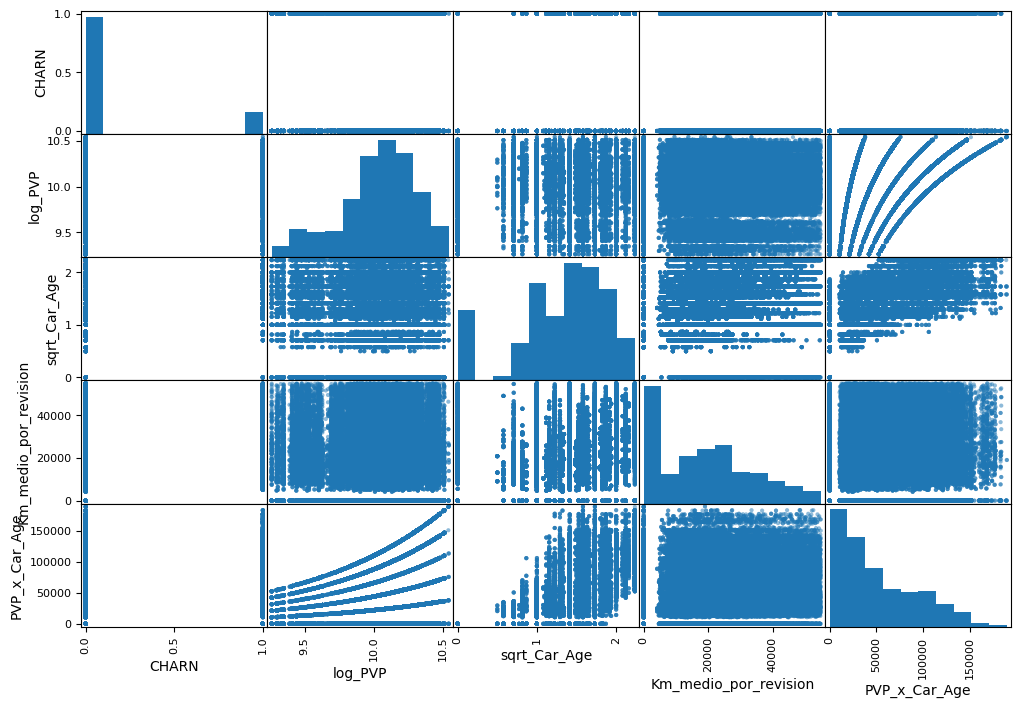

In [8]:
# Matriz de correlación con las nuevas variables
corr_cols = ['CHARN', 'log_PVP', 'sqrt_Car_Age', 'Km_medio_por_revision', 'PVP_x_Car_Age']
corr_matrix = df_customer_final[corr_cols].corr()
print(corr_matrix['CHARN'].sort_values(ascending=False))

# Visualización de relaciones
pd.plotting.scatter_matrix(df_customer_final[corr_cols], figsize=(12, 8))
plt.show()

### Preparación del modelo

In [9]:
# Definir variables independientes y dependiente
X = df_customer_final[['log_PVP', 'sqrt_Car_Age', 'Km_medio_por_revision', 'PVP_x_Car_Age']]
y = df_customer_final['CHARN']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Entrenamiento del modelo

In [10]:
# Modelo de regresión logística
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Métricas en entrenamiento
print("=== Métricas en Entrenamiento ===")
print(classification_report(y_train, model.predict(X_train)))
print("ROC AUC:", roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))

=== Métricas en Entrenamiento ===
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     61566
           1       0.37      0.03      0.06     11762

    accuracy                           0.84     73328
   macro avg       0.60      0.51      0.48     73328
weighted avg       0.77      0.84      0.77     73328

ROC AUC: 0.747416686236106


### Extracción de coeficientes Beta

In [11]:
# Extraer coeficientes
coeficientes = pd.DataFrame({
    'Variable': ['Intercepto'] + X.columns.tolist(),
    'Coeficiente': [model.intercept_[0]] + model.coef_[0].tolist(),
    'Odds_Ratio': np.exp([model.intercept_[0]] + model.coef_[0].tolist())
})

print("\nCoeficientes del Modelo:")
print(coeficientes.to_string(index=False))

# Guardar a CSV
output_path = '../../docs/model_outputs/logistic_coefficients_calculated.csv'
if os.path.exists(output_path):
    os.remove(output_path)
coeficientes.to_csv(output_path, index=False)


Coeficientes del Modelo:
             Variable  Coeficiente  Odds_Ratio
           Intercepto     0.020616    1.020830
              log_PVP    -0.456684    0.633380
         sqrt_Car_Age     1.726132    5.618878
Km_medio_por_revision     0.000028    1.000028
        PVP_x_Car_Age    -0.000005    0.999995


### Guardar coeficientes Beta en una tabla de SQL Server Managment

In [ ]:
def guardar_coeficientes_en_sql(coefficients_df, table_name="Coeficientes_churn"):
    """
    Guarda los coeficientes del modelo en una tabla permanente en SQL Server
    
    Args:
        coefficients_df: DataFrame con los coeficientes (el que guardaste como CSV)
        table_name: Nombre de la tabla destino en SQL Server
    """
    try:
        # Conexión a SQL Server Local 
        conn = pyodbc.connect(local_conn_str)
        cursor = conn.cursor()
        
        logging.info(f"\nIniciando guardado de coeficientes en tabla {table_name}...")
        
        # 1. Eliminar tabla si ya existe
        cursor.execute(f"IF OBJECT_ID('{table_name}', 'U') IS NOT NULL DROP TABLE {table_name}")
        conn.commit()
        
        # 2. Crear tabla para coeficientes
        create_table_sql = f"""
        CREATE TABLE {table_name} (
            variable NVARCHAR(100) PRIMARY KEY,
            coeficiente FLOAT,
            odds_ratio FLOAT,
            fecha_actualizacion DATETIME DEFAULT GETDATE()
        );
        """
        cursor.execute(create_table_sql)
        conn.commit()
        
        # 3. Insertar datos
        insert_sql = f"INSERT INTO {table_name} (variable, coeficiente, odds_ratio) VALUES (?, ?, ?)"
        
        # Preparar datos (convertir DataFrame a lista de tuplas)
        data_to_insert = [
            (row['Variable'], row['Coeficiente'], row['Odds_Ratio'])
            for _, row in coefficients_df.iterrows()
        ]
        
        cursor.fast_executemany = True
        cursor.executemany(insert_sql, data_to_insert)
        conn.commit()
        
        # Verificar inserción
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        count = cursor.fetchone()[0]
        
        logging.info(f"✓ Coeficientes guardados correctamente en {table_name}. Filas insertadas: {count}")
        
        # Opcional: Mostrar preview
        cursor.execute(f"SELECT TOP 5 * FROM {table_name} ORDER BY variable")
        logging.info("\nPreview de los datos guardados:")
        for row in cursor.fetchall():
            logging.info(f"- {row.variable}: Coef={row.coeficiente:.4f}, OR={row.odds_ratio:.4f}")
            
    except Exception as e:
        logging.error(f"Error al guardar coeficientes: {str(e)}")
    finally:
        if 'conn' in locals():
            conn.close()

guardar_coeficientes_en_sql(coeficientes)

2025-03-29 00:42:22,371 - INFO - 
Iniciando guardado de coeficientes en tabla Coeficientes_churn...
2025-03-29 00:42:22,434 - INFO - ✓ Coeficientes guardados correctamente en Coeficientes_churn. Filas insertadas: 5
2025-03-29 00:42:22,439 - INFO - 
Preview de los datos guardados:
2025-03-29 00:42:22,441 - INFO - - Intercepto: Coef=0.0206, OR=1.0208
2025-03-29 00:42:22,443 - INFO - - Km_medio_por_revision: Coef=0.0000, OR=1.0000
2025-03-29 00:42:22,445 - INFO - - log_PVP: Coef=-0.4567, OR=0.6334
2025-03-29 00:42:22,447 - INFO - - PVP_x_Car_Age: Coef=-0.0000, OR=1.0000
2025-03-29 00:42:22,447 - INFO - - sqrt_Car_Age: Coef=1.7261, OR=5.6189


### Evaluación del modelo


=== Métricas en Test ===
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     15427
           1       0.37      0.03      0.06      2906

    accuracy                           0.84     18333
   macro avg       0.61      0.51      0.49     18333
weighted avg       0.77      0.84      0.78     18333

ROC AUC: 0.7460269445633234


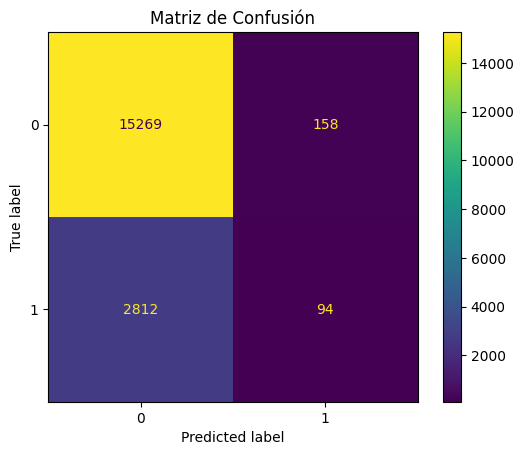

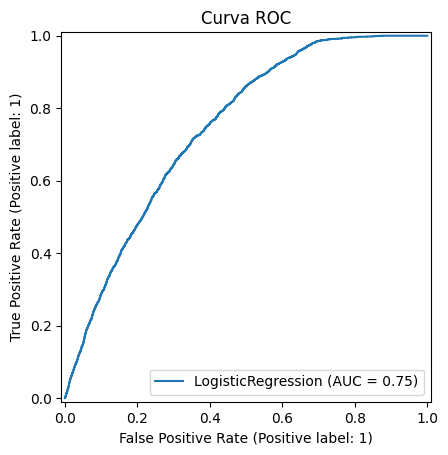

In [15]:
# Evaluación en test
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\n=== Métricas en Test ===")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Matriz de Confusión")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("Curva ROC")
plt.show()